In [2]:
%load_ext autoreload
%autoreload 2

from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np


from src.utils import load_data, load_config, load_merged_features
from src import utils_stats as us
from src.utils_mca import compute_mca

import seaborn as sns
import matplotlib.pyplot as plt

# Reproduce Paper Results

This notebook is dedicated to reproduce the results presented in the Paper, "A psycholinguistic study of the traumatic discourse used by intimate partners violence"


In [3]:
config = load_config("config.yaml")

#data = load_merged_features(config)
#data = data.replace(["MANQUANT"], 0)
#data = data.replace([np.inf, -np.inf], 0)
#final_data = data[["code"] +Q1_linguistic_features+Q2_linguistic_features+Q3_linguistic_features+study_target+socio_cols+violence_cols+conso_cols ]
data = pd.read_csv("data/final_data.csv", sep="\t")

In [4]:
linguistic_features = ['Q1_silent_break',
 'Q1_filled_break',
 'Q1_incomplete_sentence',
 'Q1_incomplete_word',
 'Q1_long_vowell',
 'Q1_connecteur',
 'Q1_non_understandable'] +[
 'Q1_MORT_EXPLICITE',
 'Q1_ON_GENERIQUE',
 #'Q1_ON_NOUS',
 'Q1_ON_QUELQU_UN',
 'Q1_PRESENT_ENNONCIATION',
 'Q1_PRESENT_GENERIQUE',
 'Q1_PRESENT_HISTORIQUE',
 'Q1_VERB_PERCEPTIONS_SENSORIELLES',
 'Q1_CORPS',
 'Q1_NOM_PERCEPTIONS_SENSORIELLES',
 'Q1_SENSATIONS_PHYSIQUES',] + ['Q1_first_personal_pronoun_sing',
 'Q1_first_personal_pronoun_plur',
 'Q1_second_personal_pronoun',
 'Q1_third_personal_pronoun',
 'Q1_verb_indicatif_present',
 'Q1_verb_indicatif_future',
 'Q1_verb_participe_passe',
 'Q1_verb_conditionel',
 'Q1_verb_indicatif_imparfait'] + ['Q1_PE',
 'Q1_LCC',
 'Q1_LSC',
 'Q1_degree_average',
 'Q1_degree_std',
 'Q1_L1',
 'Q1_L2',
 'Q1_L3',
 'Q1_transitivity',
 'Q1_average_clustering',
 'Q1_diameter_g0',
 'Q1_average_shrotest_path_g0'] + [ 'Q1_passive_count_norm', 
                                   'Q1_passive_percentages',]+ [
              'Q1_labMT',"Q1_textblob_polarity"]

Q1_linguistic_features = [f.replace("Q1","Q1") for f in linguistic_features]
Q2_linguistic_features = [f.replace("Q1","Q2") for f in linguistic_features]
Q3_linguistic_features = [f.replace("Q1","Q3") for f in linguistic_features]

study_target = [ "PCL_REVIVISCENCES","PCL_DISSO","TOTAL_PCL_y","TOTAL_DES_y", "PA_Q2","TYPE_TRAUMA"]

socio_cols = ['AGE', 'STATUT_MARITAL', 'ENFANTS', 'NB_ENF', "source"]
socio_cols_cat = socio_cols[1:]
violence_cols = ['VIOL_SEX', 'VIOL_PHY',
       'VIOL_PSY', 'VIOL_ADM_ECO', 'VIOL_CYBER', 'VIOL_ANI', 'VIOL_MAT',
       'NB_VICTIME', 'VIOL_EXTRA_CONJ', 'RECIDIVE',"NB_PA"]

conso_cols = ['CONSO_PA','ATCD_MED', 'TRAITEMENT']

print("Number of lingusitic features: ",(len(linguistic_features)))

data[study_target].head(2)

Number of lingusitic features:  42


,PCL_REVIVISCENCES,PCL_DISSO,TOTAL_PCL_y,TOTAL_DES_y,PA_Q2,TYPE_TRAUMA
0,15,5,33,280,1.0,2
1,11,8,53,490,0.0,2


In [4]:
### addind grouped features Q1, Q2, Q3
for columns in linguistic_features:
    neutral = columns.replace("Q1", "")
    new_column = f"avg_Q1_Q2_Q3{neutral}"
    data[new_column] = data[f'Q1{neutral}'] + data[f'Q2{neutral}'] + data[f'Q3{neutral}']
    data[new_column] = data[new_column] / 3

## adding grouped features Q1 and Q3
for columns in linguistic_features:
    neutral = columns.replace("Q1", "")
    new_column = f"avg_Q1_Q3{neutral}"
    data[new_column] = data[f'Q1{neutral}'] + data[f'Q3{neutral}']
    data[new_column] = data[new_column] / 2


for source in ['Q1',"Q2","Q3","Q4","text"]:
    data[f'{source}_token_number'] =  data[f'{source}_token'].apply(len)
    
data['source_enc'] = data['source'].map({"france": 0, "quebec": 1})
data = data.replace([np.inf, -np.inf], 0)
data = data.fillna(0)

## Information for TAble 2. socioeconomic informations

In [5]:
for col in socio_cols :
    print("###")
    if col != 'AGE' and col != 'NB_ENF' :
       
        print(data[col].value_counts(normalize=True).round(3)*100)
    else : 
        print(data[col].describe())

###
count    57.000000
mean     41.421053
std      10.613245
min      22.000000
25%      35.000000
50%      40.000000
75%      48.000000
max      69.000000
Name: AGE, dtype: float64
###
STATUT_MARITAL
0    49.1
1    26.3
2    24.6
Name: proportion, dtype: float64
###
ENFANTS
1    84.2
0    15.8
Name: proportion, dtype: float64
###
count    57.000000
mean      1.719298
std       1.319556
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       7.000000
Name: NB_ENF, dtype: float64
###
source
france    66.7
quebec    33.3
Name: proportion, dtype: float64


In [279]:
for trauma_type in [1,2]:
    for col in socio_cols :
        print("###")
        print(f"Trauma type {trauma_type}")
        pop = data[data["TYPE_TRAUMA"] == trauma_type]
        if col != 'AGE' and col != 'NB_ENF' :
       
            print(pop[col].value_counts(normalize=True).round(3)*100)
        else : 
            print(pop[col].describe())

###
Trauma type 1
count    29.000000
mean     43.862069
std      10.394793
min      25.000000
25%      37.000000
50%      45.000000
75%      49.000000
max      65.000000
Name: AGE, dtype: float64
###
Trauma type 1
STATUT_MARITAL
0    58.6
2    27.6
1    13.8
Name: proportion, dtype: float64
###
Trauma type 1
ENFANTS
1    86.2
0    13.8
Name: proportion, dtype: float64
###
Trauma type 1
count    29.000000
mean      1.724138
std       1.360057
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       7.000000
Name: NB_ENF, dtype: float64
###
Trauma type 1
source
france    69.0
quebec    31.0
Name: proportion, dtype: float64
###
Trauma type 2
count    28.000000
mean     38.892857
std      10.418428
min      22.000000
25%      32.000000
50%      36.500000
75%      43.000000
max      69.000000
Name: AGE, dtype: float64
###
Trauma type 2
STATUT_MARITAL
1    39.3
0    39.3
2    21.4
Name: proportion, dtype: float64
###
Trauma type 2
ENFANTS
1    82.1
0    17.9
Name

## Informations for Table 3. Concerning the violence informations

In [14]:
for col in violence_cols :
    print("###")
    
    print(data[col].value_counts(normalize=True).round(3)*100)

###
VIOL_SEX
0    91.2
1     8.8
Name: proportion, dtype: float64
###
VIOL_PHY
1    70.2
0    29.8
Name: proportion, dtype: float64
###
VIOL_PSY
1    91.2
0     8.8
Name: proportion, dtype: float64
###
VIOL_ADM_ECO
0    94.7
1     5.3
Name: proportion, dtype: float64
###
VIOL_CYBER
0    77.2
1    22.8
Name: proportion, dtype: float64
###
VIOL_ANI
0    96.5
1     3.5
Name: proportion, dtype: float64
###
VIOL_MAT
0    77.2
1    22.8
Name: proportion, dtype: float64
###
NB_VICTIME
1    73.7
2    26.3
Name: proportion, dtype: float64
###
VIOL_EXTRA_CONJ
0    61.4
1    38.6
Name: proportion, dtype: float64
###
RECIDIVE
0    91.2
1     8.8
Name: proportion, dtype: float64
###
NB_PA
2    64.9
1    35.1
Name: proportion, dtype: float64


In [280]:
for trauma_type in [1,2]:
    for col in violence_cols :
        print("###")
        print(f"Trauma type {trauma_type}")
        pop = data[data["TYPE_TRAUMA"] == trauma_type]
        print(pop[col].value_counts(normalize=True).round(3)*100)

###
Trauma type 1
VIOL_SEX
0    89.7
1    10.3
Name: proportion, dtype: float64
###
Trauma type 1
VIOL_PHY
1    75.9
0    24.1
Name: proportion, dtype: float64
###
Trauma type 1
VIOL_PSY
1    93.1
0     6.9
Name: proportion, dtype: float64
###
Trauma type 1
VIOL_ADM_ECO
0    96.6
1     3.4
Name: proportion, dtype: float64
###
Trauma type 1
VIOL_CYBER
0    72.4
1    27.6
Name: proportion, dtype: float64
###
Trauma type 1
VIOL_ANI
0    96.6
1     3.4
Name: proportion, dtype: float64
###
Trauma type 1
VIOL_MAT
0    75.9
1    24.1
Name: proportion, dtype: float64
###
Trauma type 1
NB_VICTIME
1    65.5
2    34.5
Name: proportion, dtype: float64
###
Trauma type 1
VIOL_EXTRA_CONJ
0    72.4
1    27.6
Name: proportion, dtype: float64
###
Trauma type 1
RECIDIVE
0    82.8
1    17.2
Name: proportion, dtype: float64
###
Trauma type 1
NB_PA
2    72.4
1    27.6
Name: proportion, dtype: float64
###
Trauma type 2
VIOL_SEX
0    92.9
1     7.1
Name: proportion, dtype: float64
###
Trauma type 2
VIOL_PHY
1

## Table 4. Consomation and medications

In [20]:
for col in conso_cols + ['TYPE_TRAUMA'] :
    print("###")
    print(data[col].value_counts(normalize=True).round(3)*100)

###
CONSO_PA
0    56.1
1    43.9
Name: proportion, dtype: float64
###
ATCD_MED
0    78.9
1    21.1
Name: proportion, dtype: float64
###
TRAITEMENT
0    64.9
1    35.1
Name: proportion, dtype: float64
###
TYPE_TRAUMA
1    50.9
2    49.1
Name: proportion, dtype: float64


In [281]:
for trauma_type in [1,2]:
    for col in conso_cols :
        print("###")
        print(f"Trauma type {trauma_type}")
        pop = data[data["TYPE_TRAUMA"] == trauma_type]
        print(pop[col].value_counts(normalize=True).round(3)*100)

###
Trauma type 1
CONSO_PA
0    58.6
1    41.4
Name: proportion, dtype: float64
###
Trauma type 1
ATCD_MED
0    86.2
1    13.8
Name: proportion, dtype: float64
###
Trauma type 1
TRAITEMENT
0    65.5
1    34.5
Name: proportion, dtype: float64
###
Trauma type 2
CONSO_PA
0    53.6
1    46.4
Name: proportion, dtype: float64
###
Trauma type 2
ATCD_MED
0    71.4
1    28.6
Name: proportion, dtype: float64
###
Trauma type 2
TRAITEMENT
0    64.3
1    35.7
Name: proportion, dtype: float64


In [297]:
us.compute_khi_2_table(data, cible = ['TYPE_TRAUMA'], col_list = conso_cols + violence_cols, seuil=0.05 )

,x,y,chi2,dof,pval,cramer,power
0,TYPE_TRAUMA,RECIDIVE,8.798628,1.0,0.003015,0.392889,0.842861


In [17]:
for col in study_target :
    print("###")
    if col == "PA_Q2" :
        print(data[col].value_counts(normalize=True).round(3)*100)
    
    else : 
        print(data[col].describe())

###
count    57.000000
mean      8.368421
std       5.410412
min       0.000000
25%       4.000000
50%       8.000000
75%      12.000000
max      20.000000
Name: PCL_REVIVISCENCES, dtype: float64
###
count    57.000000
mean      3.140351
std       2.824881
min       0.000000
25%       1.000000
50%       2.000000
75%       5.000000
max      12.000000
Name: PCL_DISSO, dtype: float64
###
count    57.000000
mean     27.421053
std      17.130744
min       1.000000
25%      13.000000
50%      25.000000
75%      40.000000
max      61.000000
Name: TOTAL_PCL_y, dtype: float64
###
count      57.000000
mean      510.175439
std       450.588866
min         0.000000
25%       220.000000
50%       360.000000
75%       600.000000
max      2100.000000
Name: TOTAL_DES_y, dtype: float64
###
PA_Q2
0.0    50.9
2.0    29.8
1.0    19.3
Name: proportion, dtype: float64


In [7]:
data.filter(regex = "L3").head(2)

,Q1_L3,Q2_L3,Q3_L3,Q4_L3,text_L3,avg_Q1_Q2_Q3_L3,avg_Q1_Q3_L3
0,193.0,122.0,10786.0,83.0,28524.0,3700.333333,5489.5
1,3827.0,460.0,9469.0,523.0,93068.0,4585.333333,6648.0


In [19]:
result = pd.DataFrame()
for question in ["Q1","Q2","Q3"]:
    future = data.filter(regex = f"{question}_verb_indicatif_future").columns.to_list()
    
    text_features = [f.replace("Q1",question) for f in linguistic_features]
    r = us.compute_pearson_table(data, cible = future, col_list = text_features, seuil=0.05, method = "skipped")
    result = pd.concat([result, r], axis = 0)
result

The covariance matrix of the support data is equal to 0, try to increase support_fraction
The covariance matrix of the support data is equal to 0, try to increase support_fraction
The covariance matrix of the support data is equal to 0, try to increase support_fraction
The covariance matrix of the support data is equal to 0, try to increase support_fraction
The covariance matrix of the support data is equal to 0, try to increase support_fraction


,x,y,n,r,CI95%,p-val,BF10,power
0,Q1_verb_indicatif_future,Q1_first_personal_pronoun_plur,57,0.352878,"[0.04, 0.6]",0.027563,NaN,0.609057
1,Q1_verb_indicatif_future,Q1_second_personal_pronoun,57,0.314318,"[0.01, 0.57]",0.045347,NaN,0.526523
2,Q1_verb_indicatif_future,Q1_verb_indicatif_future,57,1.0,"[1.0, 1.0]",0.0,NaN,1
3,Q1_verb_indicatif_future,Q1_verb_conditionel,57,0.459316,"[0.19, 0.66]",0.001504,NaN,0.901162
0,Q2_verb_indicatif_future,Q2_long_vowell,57,0.620555,"[0.39, 0.78]",0.000009,NaN,0.99626
1,Q2_verb_indicatif_future,Q2_MORT_EXPLICITE,57,0.278828,"[0.0, 0.51]",0.047552,NaN,0.516397
2,Q2_verb_indicatif_future,Q2_ON_GENERIQUE,57,0.309864,"[0.04, 0.54]",0.025386,NaN,0.618484
3,Q2_verb_indicatif_future,Q2_PE,57,0.287483,"[0.01, 0.52]",0.040801,NaN,0.54256
4,Q2_verb_indicatif_future,Q2_degree_average,57,0.461008,"[0.22, 0.65]",0.000397,NaN,0.951919
5,Q2_verb_indicatif_future,Q2_degree_std,57,0.326275,"[0.06, 0.55]",0.01711,NaN,0.675205


In [21]:
data["Q3_verb_indicatif_future"].argmax()

56

In [23]:
data.loc[56]['Q3_verb_indicatif_future']

0.0686274509803921

<Axes: xlabel='Q3_verb_indicatif_future', ylabel='Q3_PE'>

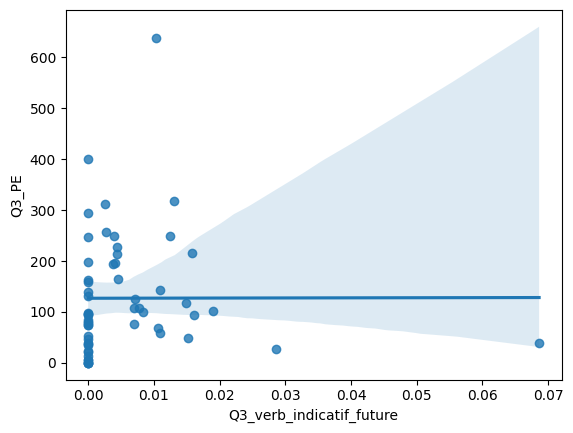

In [20]:
sns.regplot(data = data, x = "Q3_verb_indicatif_future", y = "Q3_PE")

In [282]:
for trauma_type in [1,2]:
    for col in study_target :
        print("###")
        print(f"Trauma type {trauma_type}")
        pop = data[data["TYPE_TRAUMA"] == trauma_type]
        if col == "PA_Q2" :
            print(pop[col].value_counts(normalize=True).round(3)*100)
        else : 
            print(pop[col].describe())

###
Trauma type 1
count    29.000000
mean      8.482759
std       5.546046
min       1.000000
25%       4.000000
50%       8.000000
75%      12.000000
max      20.000000
Name: PCL_REVIVISCENCES, dtype: float64
###
Trauma type 1
count    29.000000
mean      2.827586
std       2.330986
min       0.000000
25%       2.000000
50%       2.000000
75%       4.000000
max       7.000000
Name: PCL_DISSO, dtype: float64
###
Trauma type 1
count    29.000000
mean     27.137931
std      16.286989
min       3.000000
25%      14.000000
50%      24.000000
75%      40.000000
max      61.000000
Name: TOTAL_PCL_y, dtype: float64
###
Trauma type 1
count      29.000000
mean      444.827586
std       431.191213
min        40.000000
25%       220.000000
50%       290.000000
75%       440.000000
max      2100.000000
Name: TOTAL_DES_y, dtype: float64
###
Trauma type 1
PA_Q2
0.0    58.6
1.0    24.1
2.0    17.2
Name: proportion, dtype: float64
###
Trauma type 2
count    28.000000
mean      8.250000
std       5.365

In [284]:
us.compute_wilc_table(data, ["TYPE_TRAUMA_enc"],study_target, seuil=0.5)


,x,y,stats,pval,cohen,power
0,TYPE_TRAUMA_enc,TOTAL_DES_y,1.484505,0.137675,0.295886,0.067933
1,TYPE_TRAUMA_enc,PA_Q2,1.532392,0.125426,0.479060,0.205591


## Table 5. Concerning the length if the data

In [18]:
for source in ['Q1',"Q2","Q3","Q4","text"]:
    print("####")
    print(data[f'{source}_token'].apply(len).describe())
    print(data[f'{source}_token'].apply(len).sum())

####
count      57.000000
mean     1070.561404
std       941.889553
min       241.000000
25%       522.000000
50%       813.000000
75%      1306.000000
max      5509.000000
Name: Q1_token, dtype: float64
61022
####
count      57.000000
mean      395.947368
std       381.677005
min         6.000000
25%       120.000000
50%       261.000000
75%       569.000000
max      1401.000000
Name: Q2_token, dtype: float64
22569
####
count      57.000000
mean     1011.649123
std       849.114675
min         0.000000
25%       465.000000
50%       793.000000
75%      1354.000000
max      4740.000000
Name: Q3_token, dtype: float64
57664
####
count     57.000000
mean     374.754386
std      198.676269
min        0.000000
25%      211.000000
50%      371.000000
75%      507.000000
max      980.000000
Name: Q4_token, dtype: float64
21361
####
count      57.000000
mean     2852.912281
std      1363.721278
min       693.000000
25%      1845.000000
50%      2625.000000
75%      3513.000000
max      7408.00

In [269]:
for trauma_type in [1,2]:
    for source in ['Q1',"Q2","Q3","text"]:
        print("####")
        print(f"Trauma type {trauma_type}, Question {source}")
        print(data[data.TYPE_TRAUMA==trauma_type][f'{source}_token'].apply(len).describe())
        print(data[data.TYPE_TRAUMA==trauma_type][f'{source}_token'].apply(len).sum())

####
Trauma type 1, Question Q1
count      29.000000
mean     1276.793103
std      1037.458033
min       308.000000
25%       637.000000
50%       901.000000
75%      1675.000000
max      5509.000000
Name: Q1_token, dtype: float64
37027
####
Trauma type 1, Question Q2
count      29.000000
mean      339.793103
std       361.157403
min        11.000000
25%        90.000000
50%       216.000000
75%       414.000000
max      1401.000000
Name: Q2_token, dtype: float64
9854
####
Trauma type 1, Question Q3
count      29.000000
mean      750.379310
std       616.390264
min         0.000000
25%       240.000000
50%       689.000000
75%      1090.000000
max      2469.000000
Name: Q3_token, dtype: float64
21761
####
Trauma type 1, Question text
count      29.000000
mean     2755.689655
std      1339.960290
min       693.000000
25%      1845.000000
50%      2403.000000
75%      3428.000000
max      5875.000000
Name: text_token, dtype: float64
79915
####
Trauma type 2, Question Q1
count      28.000

In [276]:
col_list = data.filter(regex = "token_number").columns.tolist()
print(col_list)
target = ['TYPE_TRAUMA_enc']
us.compute_wilc_table(data, cible = target, col_list=col_list, seuil = 0.5)

['Q1_token_number', 'Q2_token_number', 'Q3_token_number', 'Q4_token_number', 'text_token_number']


,x,y,stats,pval,cohen,power
0,TYPE_TRAUMA_enc,Q1_token_number,-2.370419,0.017768,-0.453337,0.179849
1,TYPE_TRAUMA_enc,Q2_token_number,1.221125,0.222039,0.300264,0.070051
2,TYPE_TRAUMA_enc,Q3_token_number,2.394362,0.016649,0.654274,0.428303


## Comparing the two corpus Trauma type 1 et 2

In [209]:
##
data['TYPE_TRAUMA_enc'] = data['TYPE_TRAUMA'] - 1
target = "TYPE_TRAUMA_enc"
results = pd.DataFrame()
psy_features = study_target 
for question in ["Q1","Q2","Q3"]:
    text_features = [f.replace("Q1",question) for f in linguistic_features]
    new_results = us.compute_wilc_table(data, [target],psy_features+text_features, seuil=0.05)
    #print(new_results)
    results = pd.concat([results, new_results], axis=0)
results

,x,y,stats,pval,cohen,power
0,TYPE_TRAUMA_enc,Q1_connecteur,-2.027227,0.042639,-0.582375,0.328607
1,TYPE_TRAUMA_enc,Q1_MORT_EXPLICITE,2.234738,0.025435,0.847287,0.700330
2,TYPE_TRAUMA_enc,Q1_PRESENT_GENERIQUE,2.202813,0.027608,0.459695,0.186015
3,TYPE_TRAUMA_enc,Q1_PE,-2.665723,0.007682,-0.504943,0.233582
4,TYPE_TRAUMA_enc,Q1_degree_average,-2.729573,0.006342,-0.737345,0.549029
5,TYPE_TRAUMA_enc,Q1_degree_std,-2.601874,0.009272,-0.600029,0.352282
6,TYPE_TRAUMA_enc,Q1_L1,-2.992953,0.002763,-0.738498,0.550699
7,TYPE_TRAUMA_enc,Q1_L2,-2.761498,0.005754,-0.443254,0.170337
8,TYPE_TRAUMA_enc,Q1_L3,-2.585911,0.009712,-0.314917,0.077514
9,TYPE_TRAUMA_enc,Q1_average_clustering,-2.410325,0.015938,-0.609046,0.364606


In [8]:
data['TYPE_TRAUMA_enc'] = data['TYPE_TRAUMA'] - 1
target = "TYPE_TRAUMA_enc"
results = pd.DataFrame()
psy_features = study_target 

us.compute_anova_table(data, [target],["PA_Q2"], seuil=0.5)


,x,y,p-unc,np2,power
0,TYPE_TRAUMA_enc,PA_Q2,0.076054,0.056108,0.732645


In [15]:
data.groupby(by = "TYPE_TRAUMA_enc")['suicical_attempt'].value_counts(normalize=True)

TYPE_TRAUMA_enc  suicical_attempt
0                0                   0.827586
                 1                   0.172414
1                0                   0.571429
                 1                   0.428571
Name: proportion, dtype: float64

In [17]:
data['suicical_attempt'].value_counts(normalize=True)

suicical_attempt
0    0.701754
1    0.298246
Name: proportion, dtype: float64

In [19]:
us.compute_khi2_table(data, ["suicical_attempt"], ["TYPE_TRAUMA_enc"])

AttributeError: module 'src.utils_stats' has no attribute 'compute_khi2_table'

In [18]:
data['suicical_attempt'] = data['PA_Q2'].map({0:0, 1:0, 2:1})
us.com(data, ["suicical_attempt"], ["TYPE_TRAUMA_enc"], seuil=0.5)

,x,y,stats,pval,cohen,power
0,suicical_attempt,TYPE_TRAUMA_enc,1.814076,0.069666,0.626056,0.316189


In [299]:

target = "source_enc"
results = pd.DataFrame()
psy_features = study_target 
for question in ["Q1","Q2","Q3"]:
    text_features = [f.replace("Q1",question) for f in linguistic_features]
    new_results = us.compute_wilc_table(data, [target],psy_features+text_features, seuil=0.05)
    #print(new_results)
    results = pd.concat([results, new_results], axis=0)

results

,x,y,stats,pval,cohen,power
0,source_enc,PCL_REVIVISCENCES,2.293757,0.021804,0.668191,0.393873
1,source_enc,PCL_DISSO,2.657711,0.007867,0.616147,0.326788
2,source_enc,TOTAL_PCL_y,3.021665,0.002514,0.978939,0.788895
3,source_enc,TOTAL_DES_y,2.268364,0.023307,0.940450,0.748528
4,source_enc,Q1_silent_break,-2.886240,0.003899,-0.543730,0.242379
5,source_enc,Q1_filled_break,-3.554899,0.000378,-0.997670,0.807078
6,source_enc,Q1_long_vowell,-3.842677,0.000122,-0.771915,0.535294
7,source_enc,Q1_connecteur,2.048299,0.040531,0.778098,0.543762
8,source_enc,Q1_verb_conditionel,2.818527,0.004824,0.878541,0.675934
0,source_enc,PCL_REVIVISCENCES,2.293757,0.021804,0.668191,0.393873


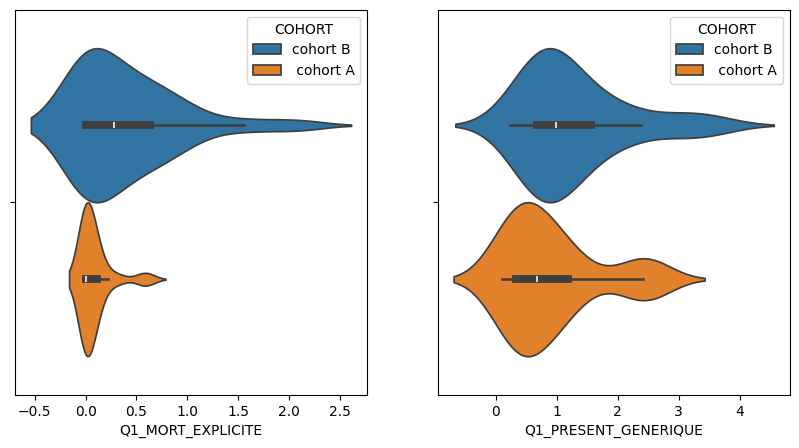

In [298]:
data["COHORT"] = data['TYPE_TRAUMA'].map({1: " cohort A", 2: "cohort B"})
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.violinplot(data=data, hue='COHORT', x='Q1_MORT_EXPLICITE',ax = ax[0])
sns.violinplot(data=data, hue='COHORT', x='Q1_PRESENT_GENERIQUE', ax = ax[1])
plt.show()

In [207]:
target = "TYPE_TRAUMA"
col_list = ['source_enc'] + socio_cols + violence_cols + conso_cols
us.compute_khi_2_table(data, [target], col_list, seuil=0.05)

,x,y,chi2,dof,pval,cramer,power


## Table 6.7.8.9 Correlation analysis for univariate 



In [212]:

question = "Q1"
coef = "skipped"
trauma_type = 1
pop = data[data['TYPE_TRAUMA']==trauma_type]
q1_features = [f.replace("Q1",question) for f in linguistic_features]
r = us.compute_pearson_table(pop,study_target , col_list = q1_features, seuil = 0.05, method = coef)
r = r[['x','y', 'r','p-val','power']]

r.sort_values(by = 'x', ascending = False).reset_index(drop = True)

,x,y,r,p-val,power
0,TOTAL_PCL_y,Q1_L3,0.621897,0.000904,0.934561
1,TOTAL_PCL_y,Q1_PE,0.440678,0.021411,0.653313
2,TOTAL_PCL_y,Q1_first_personal_pronoun_plur,0.467885,0.010482,0.747016
3,TOTAL_PCL_y,Q1_MORT_EXPLICITE,-0.378009,0.043195,0.539046
4,TOTAL_PCL_y,Q1_connecteur,0.428096,0.020517,0.65822
5,TOTAL_PCL_y,Q1_filled_break,-0.368946,0.048889,0.517359
6,TOTAL_DES_y,Q1_verb_indicatif_future,-0.392967,0.047043,0.525715
7,PCL_REVIVISCENCES,Q1_MORT_EXPLICITE,-0.454785,0.013187,0.718733
8,PCL_REVIVISCENCES,Q1_first_personal_pronoun_plur,0.381793,0.04098,0.548124
9,PCL_REVIVISCENCES,Q1_diameter_g0,-0.389453,0.036773,0.566508


In [213]:
## save all results
for coef in ["skipped"]:
    for question in ["Q1","Q2","Q3","avg_Q1_Q2_Q3","avg_Q1_Q3"]:
        source = question
        for population in [1,2]:
            
            text_features = [f.replace("Q1",question) for f in linguistic_features]
            if population == 0:
                pop = data
                pop_name = "ALL"
            else :
                pop = data[data['TYPE_TRAUMA']==population]
                pop_name = f"TRAUMA_type_{population}"
            print(f"#### {source} - {pop_name}")
            r = us.compute_pearson_table(pop,study_target , col_list = text_features, seuil = 0.05, method = coef)
            r = r[['x','y', 'r','p-val','power']]
            mask_liwc = ~r["y"].astype(str).str.contains('liwc', case=False, na=False)
            r = r[mask_liwc]
            r['power'] = r['power'].apply(lambda x : round(x,2))
            r['r'] = r['r'].apply(lambda x : round(x,2))
            r.sort_values("x").to_csv(f"results/corr/corr_{source}_{pop_name}_{coef}.csv",sep="\t")
            print(f"corr_{source}_{pop_name}_{coef} is done ! ")

#### Q1 - TRAUMA_type_1
corr_Q1_TRAUMA_type_1_skipped is done ! 
#### Q1 - TRAUMA_type_2
corr_Q1_TRAUMA_type_2_skipped is done ! 
#### Q2 - TRAUMA_type_1
corr_Q2_TRAUMA_type_1_skipped is done ! 
#### Q2 - TRAUMA_type_2
corr_Q2_TRAUMA_type_2_skipped is done ! 
#### Q3 - TRAUMA_type_1
corr_Q3_TRAUMA_type_1_skipped is done ! 
#### Q3 - TRAUMA_type_2
corr_Q3_TRAUMA_type_2_skipped is done ! 
#### avg_Q1_Q2_Q3 - TRAUMA_type_1
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
corr_avg_Q1_Q2_Q3_TRAUMA_type_1_skipped is done ! 
#### avg_Q1_Q2_Q3 - TRAUMA_type_2
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_Q1_Q2_Q3_labMT'
'avg_Q1_Q2_Q3_textblob_polarity'
'avg_

In [118]:
import pingouin as pg

question = "Q1"
trauma_type = 1
target = "TOTAL_PCL_y"
pop = data[data['TYPE_TRAUMA']==trauma_type]
text_features = [f.replace("Q1",question) for f in linguistic_features]
r = us.compute_pearson_table(pop, [target] , col_list = text_features, seuil = 0.5, method = coef)
select = r.sort_values(by = 'p-val', ascending = True).reset_index(drop = True)["y"].tolist()[:10]
print(select)
select = select #+ ["source_enc"]
lm = pg.linear_regression(pop[select], pop[target])
lm.round(3)

['Q1_L3', 'Q1_first_personal_pronoun_plur', 'Q1_connecteur', 'Q1_PE', 'Q1_MORT_EXPLICITE', 'Q1_filled_break', 'Q1_diameter_g0', 'Q1_VERB_PERCEPTIONS_SENSORIELLES', 'Q1_verb_indicatif_present', 'Q1_L2']


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,39.353,26.214,1.501,0.151,0.778,0.655,-15.721,94.427
1,Q1_L3,0.001,0.000,2.211,0.040,0.778,0.655,0.000,0.001
2,Q1_first_personal_pronoun_plur,2516.942,593.172,4.243,0.000,0.778,0.655,1270.734,3763.149
3,Q1_connecteur,3.168,1.096,2.890,0.010,0.778,0.655,0.865,5.470
4,Q1_PE,-0.013,0.039,-0.345,0.734,0.778,0.655,-0.095,0.068
5,Q1_MORT_EXPLICITE,-33.240,13.817,-2.406,0.027,0.778,0.655,-62.269,-4.210
6,Q1_filled_break,-0.099,1.576,-0.063,0.951,0.778,0.655,-3.409,3.211
7,Q1_diameter_g0,-3.974,3.272,-1.215,0.240,0.778,0.655,-10.849,2.900
8,Q1_VERB_PERCEPTIONS_SENSORIELLES,22.665,7.308,3.101,0.006,0.778,0.655,7.312,38.019
9,Q1_verb_indicatif_present,-44.541,22.561,-1.974,0.064,0.778,0.655,-91.941,2.858


In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Example setup (ensure you've defined 'data' and 'linguistic_features' appropriately)
question = "Q2"
trauma_type = 2
target = "PCL_DISSO"
coef = "skipped"

def compute_linear_regression(data, question, trauma_type, target, coef, vif_threshold=10, print_summary=False):
    pop = data[data['TYPE_TRAUMA']==trauma_type]
    text_features = [f.replace("Q1", question) for f in linguistic_features]
    r = us.compute_pearson_table(pop, [target], col_list=text_features, seuil=0.1, method=coef)
    select = r.sort_values(by='p-val', ascending=True).reset_index(drop=True)["y"].tolist()[:10]
    
    print(select)

    # Selecting the predictors based on the Pearson table results
    X = pop[select]
    y = pop[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert the scaled array back into a DataFrame, preserving column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_scaled_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

    # Remove features with high VIF values (common threshold: VIF > 5 or 10)
    high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['feature'].tolist()
    X_scaled_df = X_scaled_df.drop(columns=high_vif_features)
    if print_summary:
        print("Removed high VIF features:", high_vif_features)
        print("Remaining features:", X_scaled_df.columns.tolist())

    # Add a constant to the normalized data (the intercept)
    X_with_const = add_constant(X_scaled_df)

    # Initialize and fit the linear regression model
    linear_model = sm.OLS(y, X_with_const).fit(cov_type='HC3')

    # Display the summary of the model
    if print_summary:
        print(linear_model.summary())

    # To see the parameters
    if print_summary:
        print("Parameters from Lasso Regression:")
        print(linear_model.params)

    # Optionally, extracting detailed results into a DataFrame
    results_df = pd.DataFrame({
        'Coefficient': linear_model.params,
        'P>|t|': linear_model.pvalues
    })
    if print_summary:
        print("Detailed Regression Results:")
        print(results_df)


    model_summary = {
        'F-statistic': linear_model.fvalue,
        'Prob(F-statistic)': linear_model.f_pvalue,
        'R-squared': linear_model.rsquared,
        'Adjusted R-squared': linear_model.rsquared_adj,
        'AIC': linear_model.aic,
        'BIC': linear_model.bic,
        'Number of features retained': len(X_scaled_df.columns)
    }

    return model_summary

synthesis = pd.DataFrame(columns=["question","trauma_type","target","coef","F-statistic","Prob(F-statistic)","R-squared","Adjusted R-squared","AIC","BIC","Number of features retained"])
i = 0
for question in ["Q1","Q2","Q3"]:
    for trauma_type in [1,2]:
        for target in ["TOTAL_PCL_y","TOTAL_DES_y","PA_Q2","PCL_REVIVISCENCES","PCL_DISSO"]:
            for coef in ["skipped"]:
                try :
                    print(f"#### {question} - {trauma_type} - {target} - {coef}")
                    model_summary = compute_linear_regression(data, question, trauma_type, target, coef, vif_threshold=5, print_summary=False)
                    synthesis.loc[i] = pd.Series({"question":question,"trauma_type":trauma_type,"target":target,"coef":coef,**model_summary})
                    i+=1
                except Exception as e:
                    print(e)
                    continue

synthesis.to_csv("results/20240527_linear_regression_results.csv",sep="\t",index=False)

In [240]:
question = "Q2"
trauma_type = 1
target = "TOTAL_PCL_y"
coef = "skipped"

model_summary = compute_linear_regression(data, question, trauma_type, target, coef, vif_threshold=5, print_summary=True)


['Q2_transitivity', 'Q2_average_clustering', 'Q2_passive_count_norm', 'Q2_PRESENT_ENNONCIATION', 'Q2_PRESENT_GENERIQUE', 'Q2_passive_percentages', 'Q2_first_personal_pronoun_plur', 'Q2_MORT_EXPLICITE', 'Q2_degree_average']
Removed high VIF features: ['Q2_transitivity', 'Q2_average_clustering', 'Q2_degree_average']
Remaining features: ['Q2_passive_count_norm', 'Q2_PRESENT_ENNONCIATION', 'Q2_PRESENT_GENERIQUE', 'Q2_passive_percentages', 'Q2_first_personal_pronoun_plur', 'Q2_MORT_EXPLICITE']
                            OLS Regression Results                            
Dep. Variable:            TOTAL_PCL_y   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     8.795
Date:                Mon, 27 May 2024   Prob (F-statistic):           5.96e-05
Time:                        17:24:56   Log-Likelihood:                -106.79
No. Observations:               

## Table 11.PA_Q2 and oridninal regression

In [253]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np


def compute_ordered_linear_regression(data, question, trauma_type, target, coef, vif_threshold=10, print_summary=False):
    pop = data[data['TYPE_TRAUMA']==trauma_type]
    text_features = [f.replace("Q1", question) for f in linguistic_features]
    r = us.compute_pearson_table(pop, [target], col_list=text_features, seuil=0.1, method=coef)
    select = r.sort_values(by='p-val', ascending=True).reset_index(drop=True)['y'].tolist()[:10]
    print("Initial selected features:", select)

    X = pop[select]
    y = pop[target]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert the scaled array back into a DataFrame, preserving column names
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_scaled_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

    # Remove features with high VIF values (common threshold: VIF > 5 or 10)
    high_vif_features = vif_data[vif_data['VIF'] > vif_threshold]['feature'].tolist()
    X_scaled_df = X_scaled_df.drop(columns=high_vif_features)
    if print_summary:
        print("Removed high VIF features:", high_vif_features)
        print("Remaining features:", X_scaled_df.columns.tolist())

    # Fit the Ordinal Logistic Regression Model
    mod = OrderedModel(y, X_scaled_df, distr='logit')
    results = mod.fit(method='bfgs', disp=False)  # Using BFGS algorithm for optimization

    if print_summary:
    # Print the summary of the ordinal logistic regression model
        print(results.summary())

        # Calculate and print McFadden's Pseudo R-squared
        print("Pseudo R-squared (McFadden's):", results.prsquared)

    
    model_summary = {'chi-squared statistic': results.llr,
        'Prob(chi-squared statistic)': results.llr_pvalue,
        'R-squared': results.prsquared,
        'AIC': results.aic,
        'BIC': results.bic,
        'Number of features retained': len(X_scaled_df.columns)
    }

    coefficients_df = pd.DataFrame({
    'Coefficient': results.params,
    'Std Err': results.bse,
    'z': results.tvalues,
    'P>|z|': results.pvalues,
    'Conf. Interval Lower': results.conf_int()[0],
    'Conf. Interval Upper': results.conf_int()[1]
    }).round(3)
    
    if print_summary:
        print("Detailed Regression Results:")
        print(coefficients_df)

    return model_summary
        
    

i = 0
df_synthesis = pd.DataFrame(columns=["question","trauma_type","target","coef","chi-squared statistic","Prob(chi-squared statistic)","R-squared","AIC","BIC","Number of features retained"])
for trauma_type in [1,2]:
    for question in ["Q1","Q2","Q3"]:
        for target in ["PA_Q2"]:
            for coef in ["skipped"]:
                try :
                    print(f"#### {question} - {trauma_type} - {target} - {coef}")
                    results = compute_ordered_linear_regression(data, question, trauma_type, target,
                                       coef, vif_threshold=10, print_summary=False)
                    df_synthesis.loc[i] = pd.Series({"question":question,"trauma_type":trauma_type,"target":target,"coef":coef,**results})
                    i+=1
                except Exception as e:
                    print(e)
                    continue


df_synthesis


#### Q1 - 1 - PA_Q2 - skipped
Initial selected features: ['Q1_silent_break', 'Q1_VERB_PERCEPTIONS_SENSORIELLES', 'Q1_textblob_polarity', 'Q1_long_vowell', 'Q1_SENSATIONS_PHYSIQUES']
#### Q2 - 1 - PA_Q2 - skipped
Initial selected features: ['Q2_PE', 'Q2_degree_std', 'Q2_degree_average', 'Q2_labMT', 'Q2_L2', 'Q2_verb_indicatif_future', 'Q2_diameter_g0', 'Q2_LSC', 'Q2_L3', 'Q2_filled_break']
#### Q3 - 1 - PA_Q2 - skipped
Initial selected features: ['Q3_average_shrotest_path_g0', 'Q3_third_personal_pronoun']
#### Q1 - 2 - PA_Q2 - skipped
Initial selected features: ['Q1_CORPS', 'Q1_verb_participe_passe', 'Q1_SENSATIONS_PHYSIQUES', 'Q1_silent_break']
#### Q2 - 2 - PA_Q2 - skipped
Initial selected features: ['Q2_SENSATIONS_PHYSIQUES', 'Q2_verb_indicatif_imparfait', 'Q2_PE', 'Q2_degree_average', 'Q2_connecteur', 'Q2_L2', 'Q2_MORT_EXPLICITE', 'Q2_CORPS', 'Q2_degree_std', 'Q2_labMT']
#### Q3 - 2 - PA_Q2 - skipped
Initial selected features: ['Q3_silent_break', 'Q3_passive_percentages', 'Q3_first_

,question,trauma_type,target,coef,chi-squared statistic,Prob(chi-squared statistic),R-squared,AIC,BIC,Number of features retained
0,Q1,1,PA_Q2,skipped,17.50808,0.003631,0.314685,52.128704,61.699774,5
1,Q2,1,PA_Q2,skipped,23.447657,0.00066,0.421442,48.189126,59.127493,6
2,Q3,1,PA_Q2,skipped,4.780519,0.091606,0.085924,58.856264,64.325447,2
3,Q1,2,PA_Q2,skipped,13.676523,0.008402,0.243192,54.561055,62.554282,4
4,Q2,2,PA_Q2,skipped,30.070283,0.000092,0.534701,44.167295,56.157136,7
5,Q3,2,PA_Q2,skipped,16.409748,0.011716,0.291793,55.827831,66.485467,6


In [251]:
# Setup (assuming 'data' and 'linguistic_features' are predefined)
coef = "skipped"
question = "Q1"
trauma_type = 1
target = "PA_Q2"
compute_ordered_linear_regression(data, question, trauma_type, target, coef, vif_threshold=10, print_summary=True)

Initial selected features: ['Q1_silent_break', 'Q1_VERB_PERCEPTIONS_SENSORIELLES', 'Q1_textblob_polarity', 'Q1_long_vowell', 'Q1_SENSATIONS_PHYSIQUES']
Removed high VIF features: []
Remaining features: ['Q1_silent_break', 'Q1_VERB_PERCEPTIONS_SENSORIELLES', 'Q1_textblob_polarity', 'Q1_long_vowell', 'Q1_SENSATIONS_PHYSIQUES']
                             OrderedModel Results                             
Dep. Variable:                  PA_Q2   Log-Likelihood:                -19.064
Model:                   OrderedModel   AIC:                             52.13
Method:            Maximum Likelihood   BIC:                             61.70
Date:                Mon, 27 May 2024                                         
Time:                        18:08:22                                         
No. Observations:                  29                                         
Df Residuals:                      22                                         
Df Model:                           5    

{'chi-squared statistic': 17.508079668105957,
 'Prob(chi-squared statistic)': 0.003630510707077058,
 'R-squared': 0.31468533318450365,
 'AIC': 52.128703562082805,
 'BIC': 61.69977437198812,
 'Number of features retained': 5}

In [254]:
df_synthesis.to_csv("results/20240527_ordered_linear_regression_results.csv",sep="\t",index=False)

In [245]:
df_synthesis

,question,trauma_type,target,coef,chi-squared statistic,Prob(chi-squared statistic),R-squared,AIC,BIC,Number of features retained
0,Q1,1,TOTAL_PCL_y,skipped,39.633984,0.000004,0.218441,203.806231,246.192401,8
1,Q1,1,PA_Q2,skipped,17.50808,0.003631,0.314685,52.128704,61.699774,5
2,Q1,1,PCL_REVIVISCENCES,skipped,19.021771,0.001904,0.124896,171.27916,197.257781,5
3,Q1,1,PCL_DISSO,skipped,17.203788,0.008563,0.173267,106.086867,122.494417,6
4,Q1,2,TOTAL_PCL_y,skipped,5.438321,0.245205,0.032732,208.710514,240.683422,4
5,Q1,2,TOTAL_DES_y,skipped,10.060497,0.073539,0.055565,230.997778,270.963913,5
6,Q1,2,PA_Q2,skipped,13.676523,0.008402,0.243192,54.561055,62.554282,4
7,Q1,2,PCL_REVIVISCENCES,skipped,15.577107,0.003642,0.101834,177.388381,204.032471,4
8,Q1,2,PCL_DISSO,skipped,7.169616,0.027742,0.061678,131.072623,145.726872,2
9,Q2,1,TOTAL_PCL_y,skipped,36.997583,0.000026,0.203911,208.442632,252.196099,9


In [180]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

question = "Q2"
trauma_type = 2
target = "PA_Q2"
pop = data[data['TYPE_TRAUMA']==trauma_type]
text_features = [f.replace("Q1",question) for f in linguistic_features]
r = us.compute_pearson_table(pop, [target] , col_list = text_features, seuil = 0.1, method = coef)
select = r.sort_values(by = 'p-val', ascending = True).reset_index(drop = True)["y"].tolist()[:10]
print(select)
X = pop[select]
y = pop[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled array back into a DataFrame, preserving column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns,index=X.index)


# Ordinal logistic regression setup
# Note: The proportional odds model assumes the same effect of predictors across category thresholds (parallel lines assumption)
mod = OrderedModel(y, X_scaled_df, distr='logit')
results = mod.fit(method='bfgs', disp=False)  # Using BFGS algorithm for optimization

# Print the summary of the ordinal logistic regression model
# Printing summary of the model fit
print(results.summary())

# Getting pseudo R-squared using OrderedResults
pseudo_r_squared = {
    'McFadden': results.prsquared,
}
print("Pseudo R-squared (McFadden's):", pseudo_r_squared['McFadden'])

# Extract coefficients and other relevant statistics
coefficients_df = pd.DataFrame({
    'Coefficient': results.params,
    'Std Err': results.bse,
    'z': results.tvalues,
    'P>|z|': results.pvalues,
    'Conf. Interval Lower': results.conf_int()[0],
    'Conf. Interval Upper': results.conf_int()[1]
}).round(3)

print("Detailed Regression Results:")
print(coefficients_df)



['Q2_SENSATIONS_PHYSIQUES', 'Q2_verb_indicatif_imparfait', 'Q2_PE', 'Q2_degree_average', 'Q2_connecteur', 'Q2_L2', 'Q2_MORT_EXPLICITE', 'Q2_CORPS', 'Q2_degree_std']
                             OrderedModel Results                             
Dep. Variable:                  PA_Q2   Log-Likelihood:                -9.1241
Model:                   OrderedModel   AIC:                             40.25
Method:            Maximum Likelihood   BIC:                             54.90
Date:                Mon, 27 May 2024                                         
Time:                        15:22:54                                         
No. Observations:                  28                                         
Df Residuals:                      17                                         
Df Model:                           9                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

In [63]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools import add_constant

# Example setup (ensure you've defined 'data' and 'linguistic_features' appropriately)
question = "Q2"
trauma_type = 1
pop = data[data['TYPE_TRAUMA']==trauma_type]
text_features = [f.replace("Q1", question) for f in linguistic_features]
r = us.compute_pearson_table(pop, ["TOTAL_DES_y"], col_list=text_features, seuil=0.5, method = coef)
select = r.sort_values(by='p-val', ascending=True).reset_index(drop=True)["y"].tolist()[:10]
print(select)

# Selecting the predictors based on the Pearson table results
X = pop[select]
y = pop['TOTAL_PCL_y']

# Add a constant to the model (the intercept)
X = add_constant(X)

# Initialize and fit the Lasso model
# Note: alpha in statsmodels is equivalent to L1_wt in regularized regression
lasso_model = sm.OLS(y, X).fit()

# Display the summary of the model
print(lasso_model.summary())

# To see the parameters
print("Parameters from Lasso Regression:")
print(lasso_model.params)

# Optionally, extracting detailed results into a DataFrame
results_df = pd.DataFrame({
    'Coefficient': lasso_model.params,
    'P>|t|': lasso_model.pvalues
})

print("Detailed Regression Results:")
print(results_df)

['Q2_PRESENT_GENERIQUE', 'Q2_CORPS', 'Q2_SENSATIONS_PHYSIQUES', 'Q2_verb_conditionel', 'Q2_transitivity', 'Q2_VERB_PERCEPTIONS_SENSORIELLES', 'Q2_incomplete_word', 'Q2_first_personal_pronoun_plur', 'Q2_L1', 'Q2_average_clustering']
                            OLS Regression Results                            
Dep. Variable:            TOTAL_PCL_y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     2.278
Date:                Mon, 27 May 2024   Prob (F-statistic):             0.0617
Time:                        11:04:00   Log-Likelihood:                -109.70
No. Observations:                  29   AIC:                             241.4
Df Residuals:                      18   BIC:                             256.4
Df Model:                          10                                         
Covariance Type:            nonrobust                    

In [93]:
data.filter(regex="SPS").columns

Index(['SPS_DESESPOIR_POND', 'SPS_IDEESUICIDAIRE_POND', 'SPS_EVAL_NEG_POND',
       'SPS_HOSTILITE_POND', 'SPS_TOTAL_POND'],
      dtype='object')

In [98]:
for col in ['SPS_DESESPOIR_POND', 'SPS_IDEESUICIDAIRE_POND', 'SPS_EVAL_NEG_POND',
       'SPS_HOSTILITE_POND', 'SPS_TOTAL_POND',"TOTAL_DES_y","TOTAL_PCL_y"] : 
    print("###")
    print(col)
    print(pg.corr(data[col], data.PA_Q2, method = "skipped"))

###
SPS_DESESPOIR_POND
          n  outliers         r          CI95%     p-val     power
skipped  57         0  0.204087  [-0.06, 0.44]  0.127818  0.334611
###
SPS_IDEESUICIDAIRE_POND
          n  outliers         r         CI95%     p-val     power
skipped  57         0  0.509077  [0.29, 0.68]  0.000053  0.985994
###
SPS_EVAL_NEG_POND
          n   r  CI95%  p-val  BF10  power
skipped  57 NaN    NaN    NaN   NaN    NaN
###
SPS_HOSTILITE_POND
          n  outliers         r          CI95%     p-val     power
skipped  57         0  0.180226  [-0.08, 0.42]  0.179742  0.270896
###
SPS_TOTAL_POND
          n  outliers         r          CI95%     p-val     power
skipped  57         3  0.086231  [-0.19, 0.35]  0.535262  0.095095
###
TOTAL_DES_y
          n  outliers         r          CI95%     p-val     power
skipped  57         6 -0.018208  [-0.29, 0.26]  0.899083  0.051547
###
TOTAL_PCL_y
          n  outliers         r          CI95%     p-val     power
skipped  57         0  0.231693 

In [ ]:
data